# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [5]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [6]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        W1 -= eta*grad_W1
        W2 -= eta*grad_W2
        b1 -= eta*grad_b1
        b2 -= eta*grad_b2


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305335 Accuracy 0.097714
Epoch 10 Loss 2.296672 Accuracy 0.097714
Epoch 20 Loss 2.287408 Accuracy 0.097714
Epoch 30 Loss 2.277089 Accuracy 0.103429
Epoch 40 Loss 2.265467 Accuracy 0.197143
Epoch 50 Loss 2.252390 Accuracy 0.293143
Epoch 60 Loss 2.237777 Accuracy 0.396857
Epoch 70 Loss 2.221640 Accuracy 0.476286
Epoch 80 Loss 2.204079 Accuracy 0.551429
Epoch 90 Loss 2.185240 Accuracy 0.609429
Epoch 100 Loss 2.165283 Accuracy 0.637714
Epoch 110 Loss 2.144374 Accuracy 0.648000
Epoch 120 Loss 2.122673 Accuracy 0.652000
Epoch 130 Loss 2.100327 Accuracy 0.655143
Epoch 140 Loss 2.077472 Accuracy 0.658000
Epoch 150 Loss 2.054227 Accuracy 0.659429
Epoch 160 Loss 2.030694 Accuracy 0.662000
Epoch 170 Loss 2.006978 Accuracy 0.661143
Epoch 180 Loss 1.983178 Accuracy 0.664571
Epoch 190 Loss 1.959366 Accuracy 0.666000
Epoch 200 Loss 1.935597 Accuracy 0.667143
Epoch 210 Loss 1.911922 Accuracy 0.669429
Epoch 220 Loss 1.888383 Accuracy 0.673143
Epoch 230 Loss 1.865015 Accuracy 0.677714
Epo

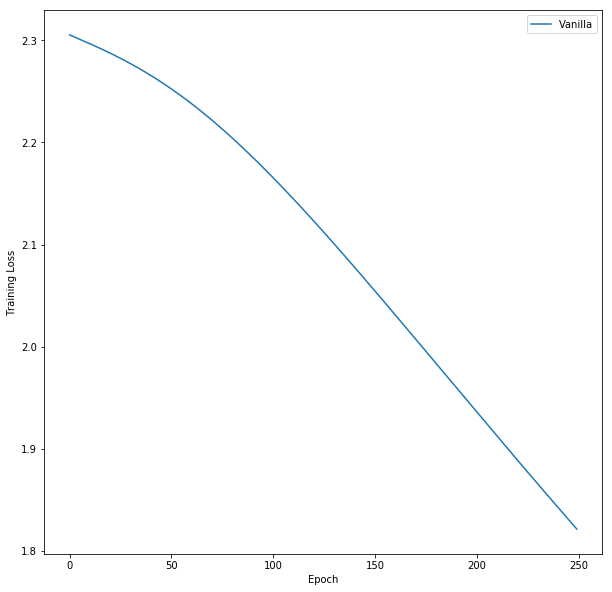

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [8]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""
beta = .5
M1 = np.zeros((n_0,n_1))
M2 = np.zeros((n_1,N))
Mb1 = np.zeros(n_1)
Mb2 = np.zeros(N)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        M1 = beta*M1 + (1-beta)*grad_W1 
        M2 = beta*M2 + (1-beta)*grad_W2
        Mb1 = beta*Mb1 + (1-beta)*grad_b1
        Mb2 = beta*Mb2 + (1-beta)*grad_b2 
        
        W1 -= eta*M1
        W2 -= eta*M2
        b1 -= eta*Mb1
        b2 -= eta*Mb2


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305343 Accuracy 0.097714
Epoch 10 Loss 2.296681 Accuracy 0.097714
Epoch 20 Loss 2.287420 Accuracy 0.097714
Epoch 30 Loss 2.277104 Accuracy 0.102857
Epoch 40 Loss 2.265486 Accuracy 0.197143
Epoch 50 Loss 2.252413 Accuracy 0.293143
Epoch 60 Loss 2.237805 Accuracy 0.396571
Epoch 70 Loss 2.221672 Accuracy 0.475714
Epoch 80 Loss 2.204116 Accuracy 0.551429
Epoch 90 Loss 2.185281 Accuracy 0.609429
Epoch 100 Loss 2.165327 Accuracy 0.637714
Epoch 110 Loss 2.144421 Accuracy 0.647429
Epoch 120 Loss 2.122723 Accuracy 0.652000
Epoch 130 Loss 2.100379 Accuracy 0.655429
Epoch 140 Loss 2.077526 Accuracy 0.657714
Epoch 150 Loss 2.054283 Accuracy 0.659429
Epoch 160 Loss 2.030751 Accuracy 0.662000
Epoch 170 Loss 2.007036 Accuracy 0.661143
Epoch 180 Loss 1.983237 Accuracy 0.664571
Epoch 190 Loss 1.959425 Accuracy 0.666000
Epoch 200 Loss 1.935656 Accuracy 0.667143
Epoch 210 Loss 1.911981 Accuracy 0.669429
Epoch 220 Loss 1.888442 Accuracy 0.673143
Epoch 230 Loss 1.865074 Accuracy 0.677714
Epo

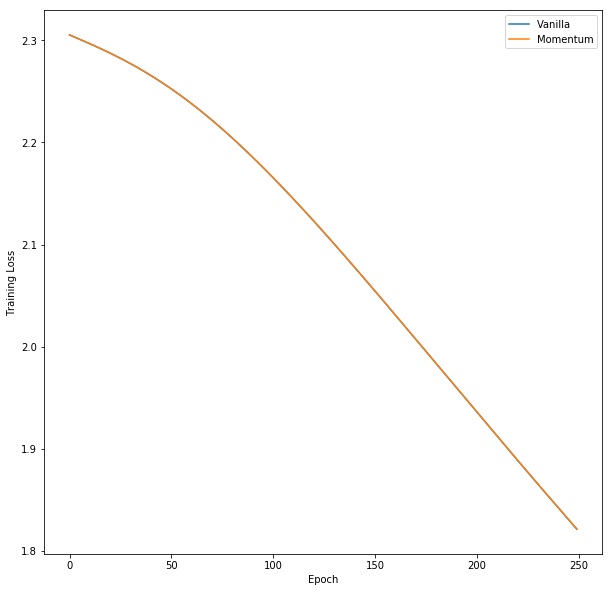

In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [10]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
beta2 = .9
epsilon = 1e-8
vW1 = np.zeros((n_0,n_1))
vW2 = np.zeros((n_1,N))
vb1 = np.zeros(n_1)
vb2 = np.zeros(N)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        vW1 = vW1*beta2 + (1-beta2)*(grad_W1**2)
        vW2 = vW2*beta2 + (1-beta2)*(grad_W2**2)
        vb1 = vb1*beta2 + (1-beta2)*(grad_b1**2)
        vb2 = vb2*beta2 + (1-beta2)*(grad_b2**2)
        
        W1 -= eta*grad_W1/np.sqrt(vW1 + epsilon)
        W2 -= eta*grad_W2/np.sqrt(vW2 + epsilon)
        b1 -= eta*grad_b1/np.sqrt(vb1 + epsilon)
        b2 -= eta*grad_b2/np.sqrt(vb2 + epsilon)

       

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.191354 Accuracy 0.553143
Epoch 10 Loss 1.415372 Accuracy 0.860857
Epoch 20 Loss 0.897830 Accuracy 0.891429
Epoch 30 Loss 0.600438 Accuracy 0.903429
Epoch 40 Loss 0.434301 Accuracy 0.911714
Epoch 50 Loss 0.337107 Accuracy 0.917429
Epoch 60 Loss 0.275375 Accuracy 0.922286
Epoch 70 Loss 0.232735 Accuracy 0.926286
Epoch 80 Loss 0.201509 Accuracy 0.928000
Epoch 90 Loss 0.177677 Accuracy 0.929143
Epoch 100 Loss 0.158802 Accuracy 0.930857
Epoch 110 Loss 0.143438 Accuracy 0.932286
Epoch 120 Loss 0.130704 Accuracy 0.933429
Epoch 130 Loss 0.119928 Accuracy 0.933143
Epoch 140 Loss 0.110699 Accuracy 0.933429
Epoch 150 Loss 0.102705 Accuracy 0.934286
Epoch 160 Loss 0.095667 Accuracy 0.934857
Epoch 170 Loss 0.089395 Accuracy 0.935429
Epoch 180 Loss 0.083823 Accuracy 0.936571
Epoch 190 Loss 0.078838 Accuracy 0.936857
Epoch 200 Loss 0.074244 Accuracy 0.936857
Epoch 210 Loss 0.070119 Accuracy 0.937143
Epoch 220 Loss 0.066408 Accuracy 0.936857
Epoch 230 Loss 0.063033 Accuracy 0.936857
Epo

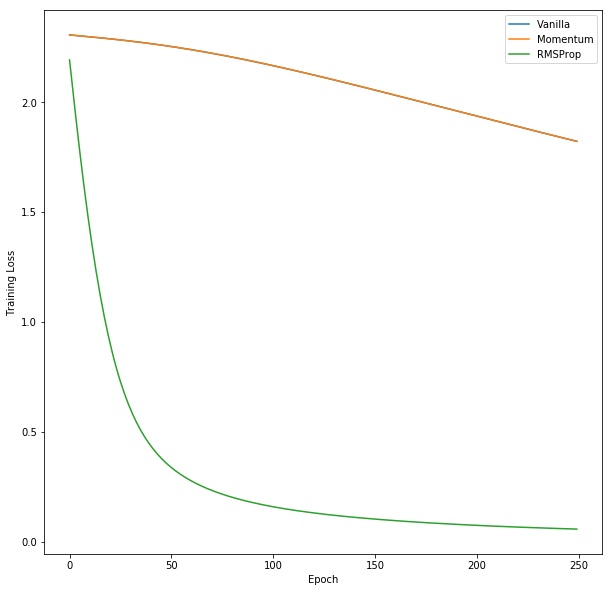

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [14]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
epsilon = 1e-8
beta1 = .9
beta2 = .99

vW1 = np.zeros((n_0,n_1))
vW2 = np.zeros((n_1,N))
vb1 = np.zeros(n_1)
vb2 = np.zeros(N)

M1 = np.zeros((n_0,n_1))
M2 = np.zeros((n_1,N))
Mb1 = np.zeros(n_1)
Mb2 = np.zeros(N)

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""


# Perform gradient descent
count = 1
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        M1 = beta1*M1 + (1-beta1)*grad_W1 
        M2 = beta1*M2 + (1-beta1)*grad_W2
        Mb1 = beta1*Mb1 + (1-beta1)*grad_b1
        Mb2 = beta1*Mb2 + (1-beta1)*grad_b2
        
        vW1 = vW1*beta2 + (1-beta2)*(grad_W1**2)
        vW2 = vW2*beta2 + (1-beta2)*(grad_W2**2)
        vb1 = vb1*beta2 + (1-beta2)*(grad_b1**2)
        vb2 = vb2*beta2 + (1-beta2)*(grad_b2**2)
        
        m1_hat = M1/(1-beta1**count)
        m2_hat = M2/(1-beta1**count)
        mb1_hat = Mb1/(1-beta1**count)
        mb2_hat = Mb2/(1-beta1**count)
        
        v1_hat = vW1/(1-beta2**count)
        v2_hat = vW2/(1-beta2**count)
        vb1_hat = vb1/(1-beta2**count)
        vb2_hat = vb2/(1-beta2**count)
        
        W1 -= eta*m1_hat/np.sqrt(v1_hat + epsilon)
        W2 -= eta*m2_hat/np.sqrt(v2_hat + epsilon)
        b1 -= eta*mb1_hat/np.sqrt(vb1_hat + epsilon)
        b2 -= eta*mb2_hat/np.sqrt(vb2_hat + epsilon)
        count += 1
        
        
        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.201192 Accuracy 0.482857
Epoch 10 Loss 1.411785 Accuracy 0.865714
Epoch 20 Loss 0.898129 Accuracy 0.893143
Epoch 30 Loss 0.599116 Accuracy 0.904286
Epoch 40 Loss 0.429425 Accuracy 0.911429
Epoch 50 Loss 0.329296 Accuracy 0.917714
Epoch 60 Loss 0.265648 Accuracy 0.922857
Epoch 70 Loss 0.221962 Accuracy 0.925143
Epoch 80 Loss 0.190547 Accuracy 0.927429
Epoch 90 Loss 0.166693 Accuracy 0.928857
Epoch 100 Loss 0.147861 Accuracy 0.930571
Epoch 110 Loss 0.132729 Accuracy 0.931143
Epoch 120 Loss 0.120222 Accuracy 0.932286
Epoch 130 Loss 0.109738 Accuracy 0.932000
Epoch 140 Loss 0.100564 Accuracy 0.932571
Epoch 150 Loss 0.092587 Accuracy 0.935714
Epoch 160 Loss 0.085708 Accuracy 0.936000
Epoch 170 Loss 0.079659 Accuracy 0.937143
Epoch 180 Loss 0.074408 Accuracy 0.937143
Epoch 190 Loss 0.069768 Accuracy 0.937143
Epoch 200 Loss 0.065504 Accuracy 0.937714
Epoch 210 Loss 0.061691 Accuracy 0.936571
Epoch 220 Loss 0.058213 Accuracy 0.936857
Epoch 230 Loss 0.055110 Accuracy 0.937143
Epo

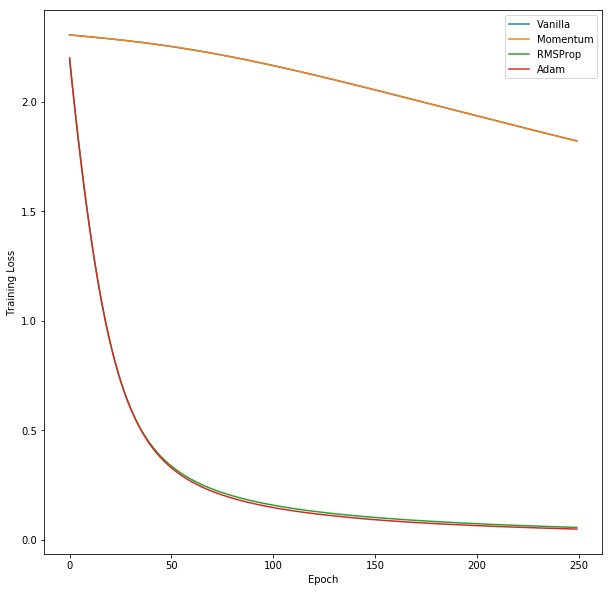

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [16]:
"""
AdaMax Gradient Descent
"""

# Hyper Parameters
eta = 2e-3
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
epsilon = 1e-8
beta1 = .9
beta2 = .99

vW1 = 0
vW2 = 0
vb1 = 0
vb2 = 0

M1 = np.zeros((n_0,n_1))
M2 = np.zeros((n_1,N))
Mb1 = np.zeros(n_1)
Mb2 = np.zeros(N)

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Ada_max_loss = []

"""
You probably need to initialize your variance and momentum here...
"""


# Perform gradient descent
count = 1
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        M1 = beta1*M1 + (1-beta1)*grad_W1 
        M2 = beta1*M2 + (1-beta1)*grad_W2
        Mb1 = beta1*Mb1 + (1-beta1)*grad_b1
        Mb2 = beta1*Mb2 + (1-beta1)*grad_b2
        
        vW1 = np.max([beta2*vW1,np.max(np.abs(grad_W1))])
        vW2 = np.max([beta2*vW2,np.max(np.abs(grad_W2))])
        vb1 = np.max([beta2*vb1,np.max(np.abs(grad_b1))])
        vb2 = np.max([beta2*vb2,np.max(np.abs(grad_b2))])
        
      
        
        W1 -= (eta*M1/vW1)/(1-beta1**count)
        W2 -= (eta*M2/vW2)/(1-beta1**count)
        b1 -= (eta*Mb1/vb1)/(1-beta1**count)
        b2 -= (eta*Mb2/vb2)/(1-beta1**count)
        count += 1
        
        
        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Ada_max_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 0.545494 Accuracy 0.896857
Epoch 10 Loss 0.111450 Accuracy 0.944571
Epoch 20 Loss 0.058127 Accuracy 0.951429
Epoch 30 Loss 0.031093 Accuracy 0.952857
Epoch 40 Loss 0.019284 Accuracy 0.953429
Epoch 50 Loss 0.013923 Accuracy 0.957429
Epoch 60 Loss 0.013225 Accuracy 0.956000
Epoch 70 Loss 0.008855 Accuracy 0.957429
Epoch 80 Loss 0.016131 Accuracy 0.957714
Epoch 90 Loss 0.008431 Accuracy 0.959714
Epoch 100 Loss 0.009302 Accuracy 0.957714
Epoch 110 Loss 0.005555 Accuracy 0.961143
Epoch 120 Loss 0.009439 Accuracy 0.956000
Epoch 130 Loss 0.011619 Accuracy 0.957143
Epoch 140 Loss 0.009744 Accuracy 0.961143
Epoch 150 Loss 0.010232 Accuracy 0.958857
Epoch 160 Loss 0.034608 Accuracy 0.947714
Epoch 170 Loss 0.009655 Accuracy 0.962000
Epoch 180 Loss 0.006697 Accuracy 0.962857
Epoch 190 Loss 0.005507 Accuracy 0.961143
Epoch 200 Loss 0.006953 Accuracy 0.961714
Epoch 210 Loss 0.005262 Accuracy 0.962000
Epoch 220 Loss 0.005288 Accuracy 0.960286
Epoch 230 Loss 0.014861 Accuracy 0.954571
Epo

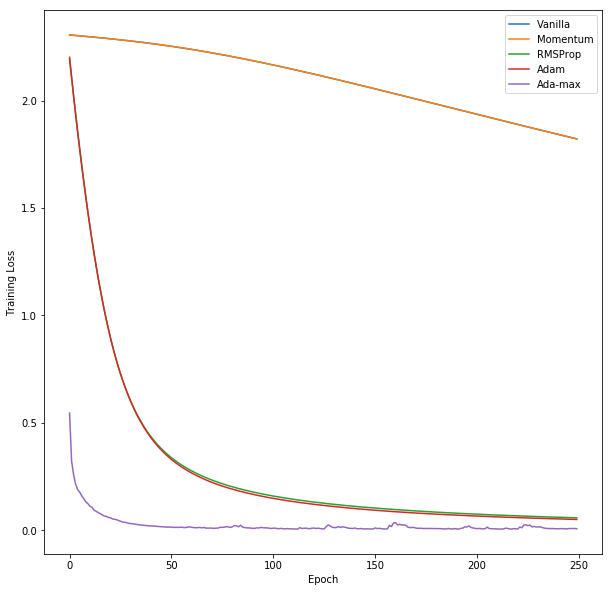

In [17]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.plot(Ada_max_loss,label='Ada-max')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()